##########
APARTADO 1 a i y 1 b i
Porcentaje de elección de las diferentes respuestas cuando se presentan varias opciones en las siguientes situaciones
Porcentaje de elección de las diferentes respuestas en base a los datos demográficos recogidos al inicio del juego:

Nodo Scene1Bedroom1.computer1.choices:
   Contestar más friamente.: 50.0%
   	('male', 'heterosexual'): 33.33333333333333%
   	('male', 'homosexual'): 33.33333333333333%
   	('male', 'bisexual'): 33.33333333333333%
   	('female', 'heterosexual'): 0.0%
   	('female', 'homosexual'): 0.0%
   	('female', 'bisexual'): 0.0%
   Contestar amablemente.: 50.0%
   	('male', 'heterosexual'): 0.0%
   	('male', 'homosexual'): 0.0%
   	('male', 'bisexual'): 0.0%
   	('female', 'heterosexual'): 0.0%
   	('female', 'homosexual'): 33.33333333333333%
   	('female', 'bisexual'): 0.0%

Nodo Scene1Bedroom1.computer2.choices3:
   Me voy ya, que es tarde: 66.66666666666666%
   	('male', 'heterosexual'): 25.0%
   	('male', 'homosexual'): 25.0%
  

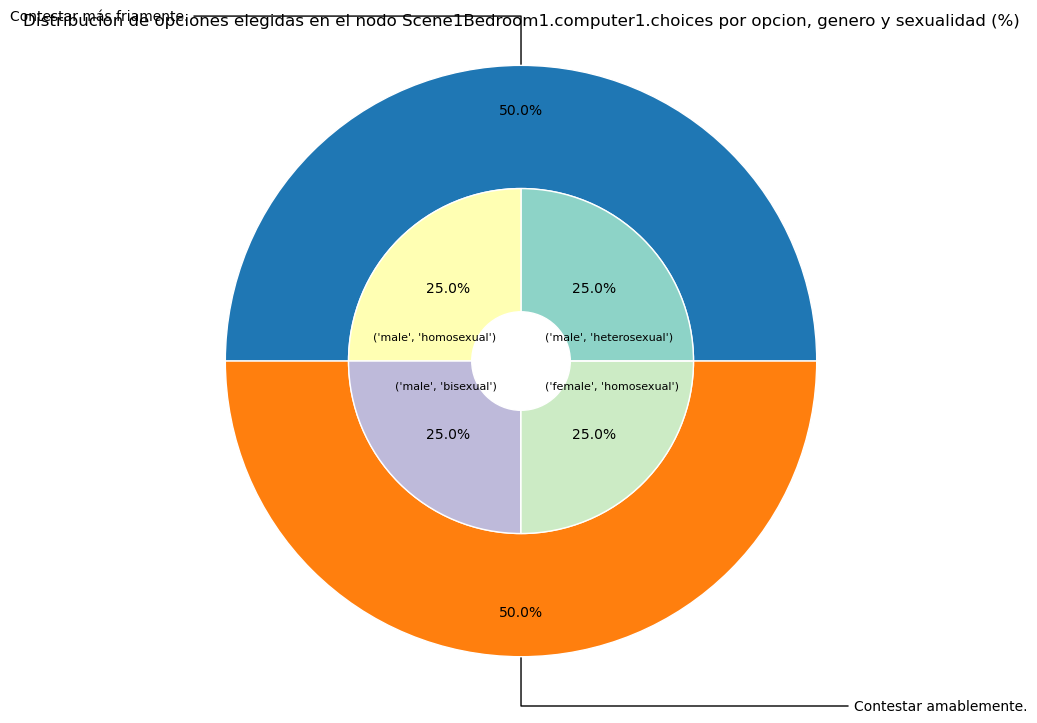

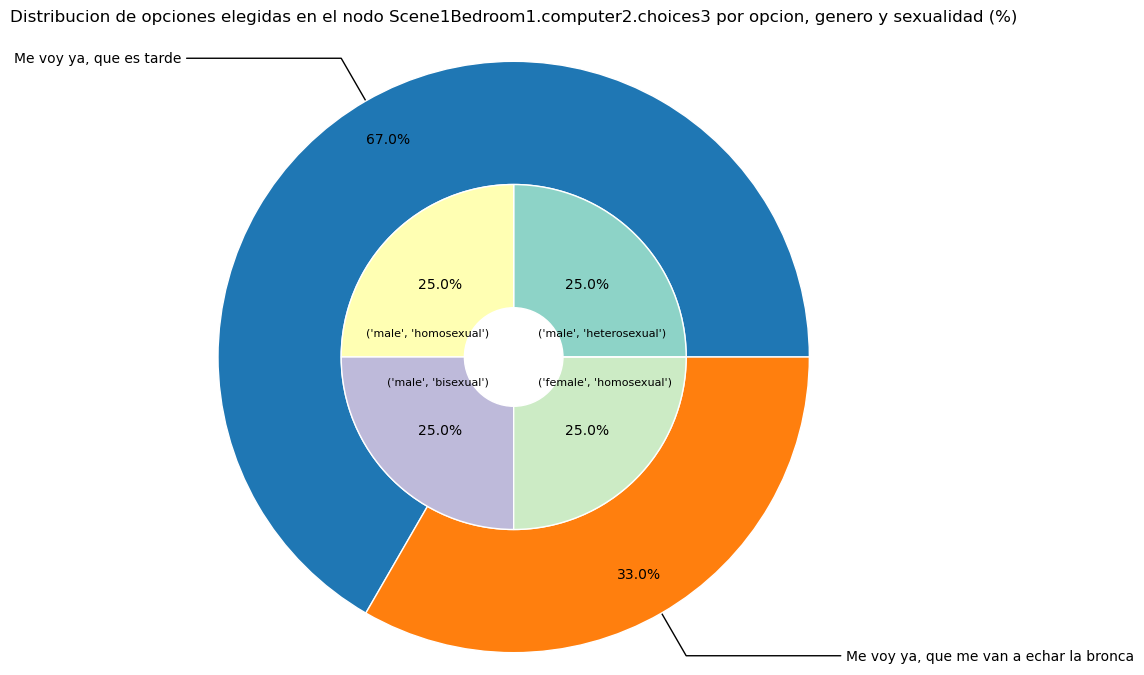

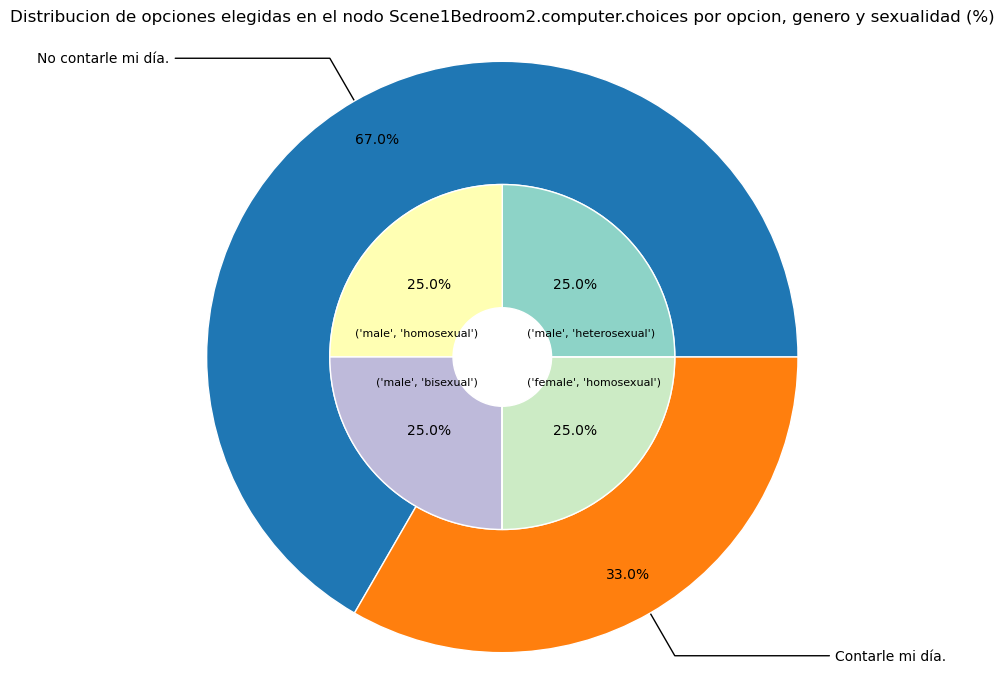

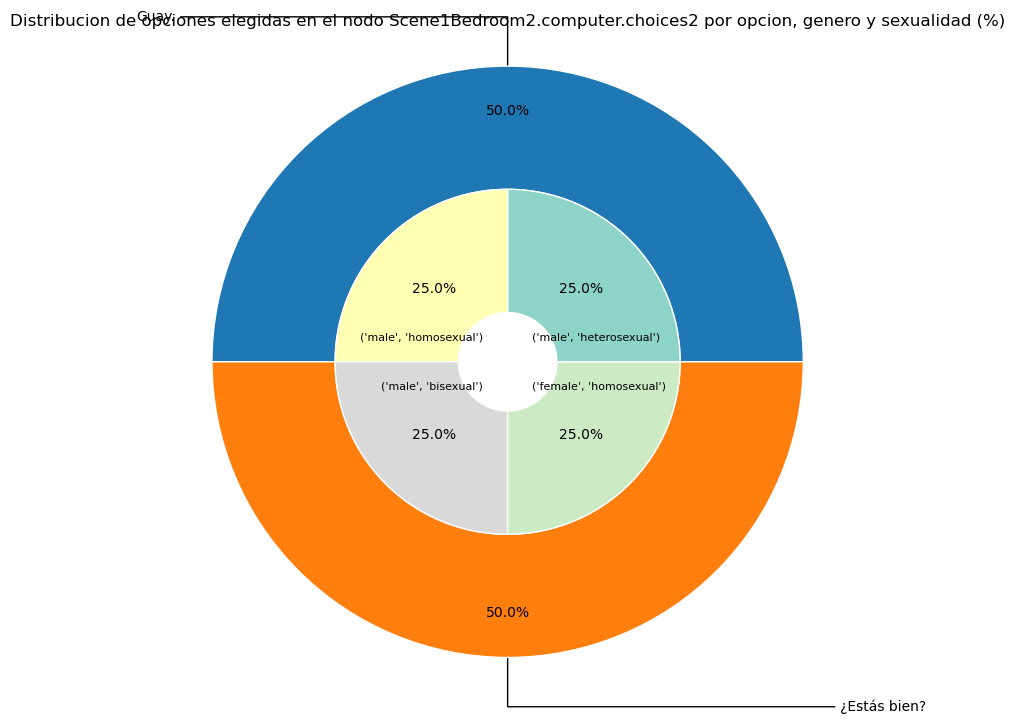

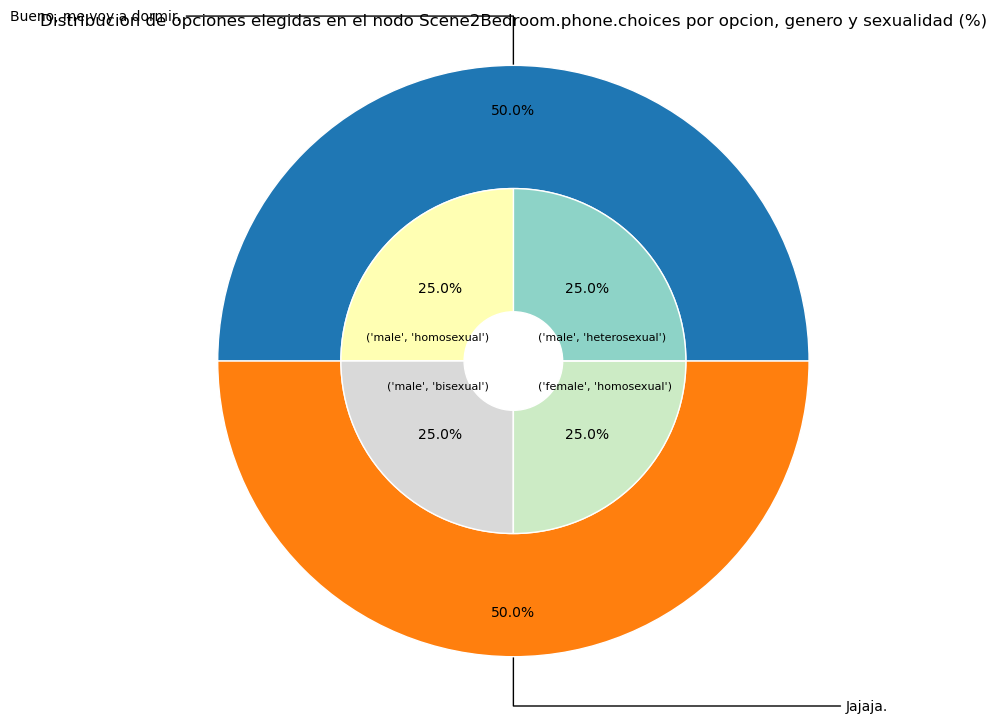

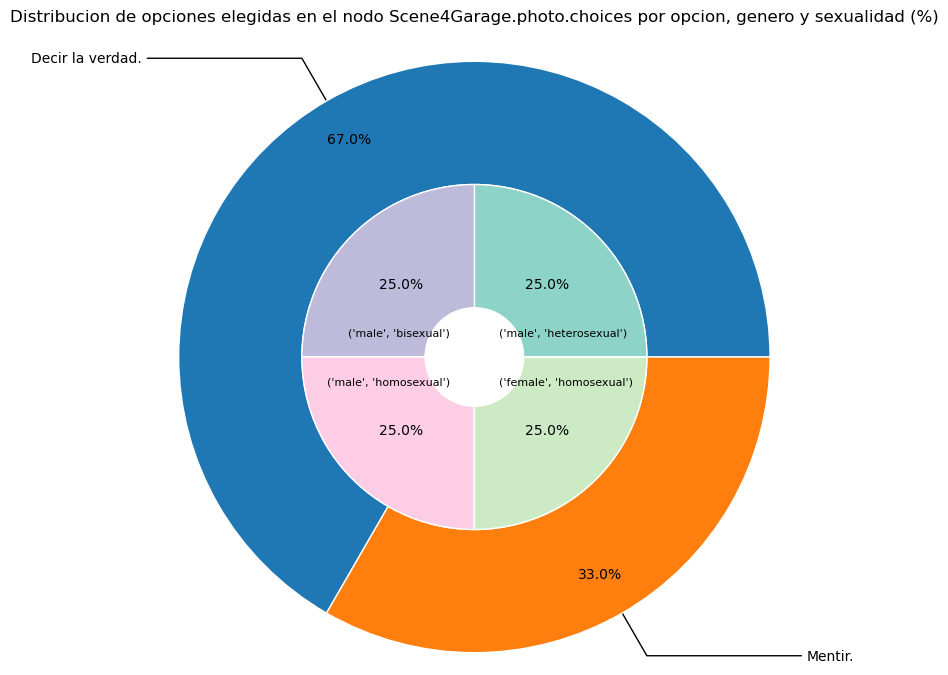

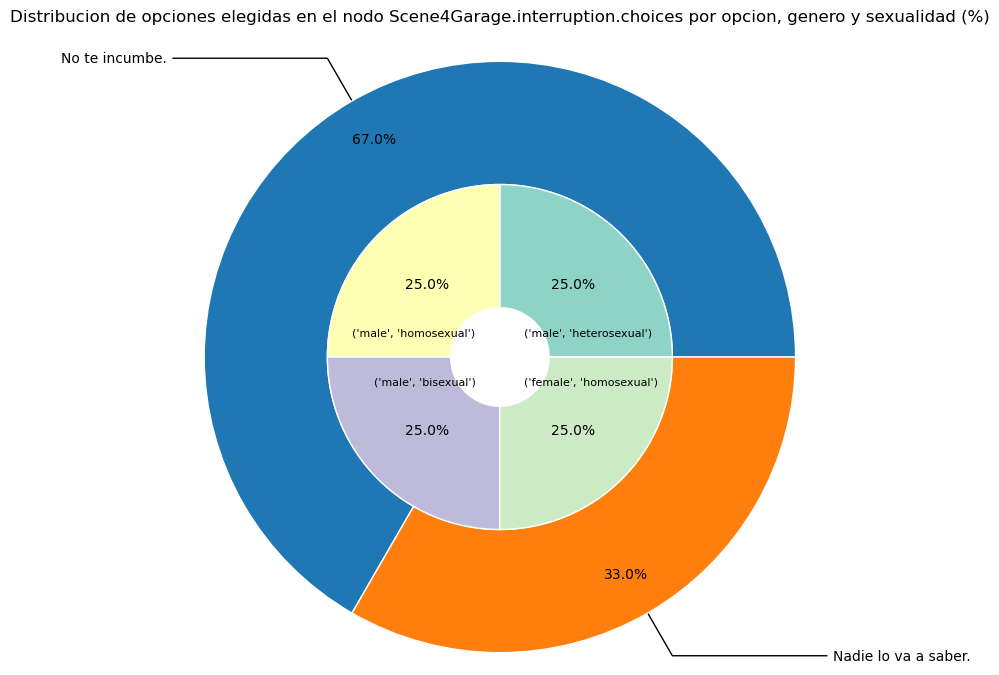

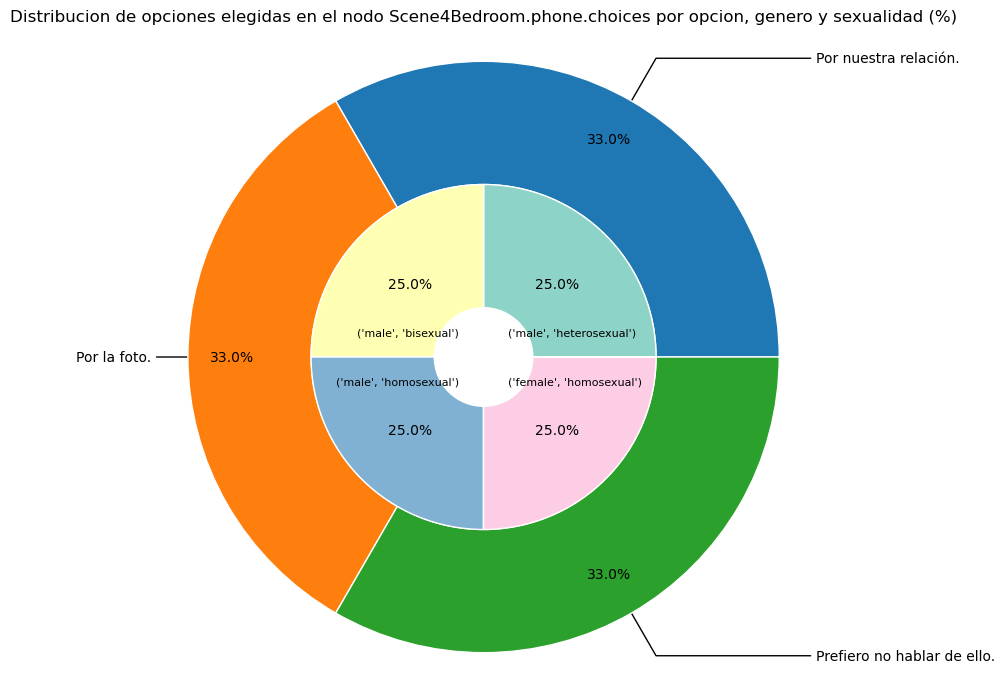

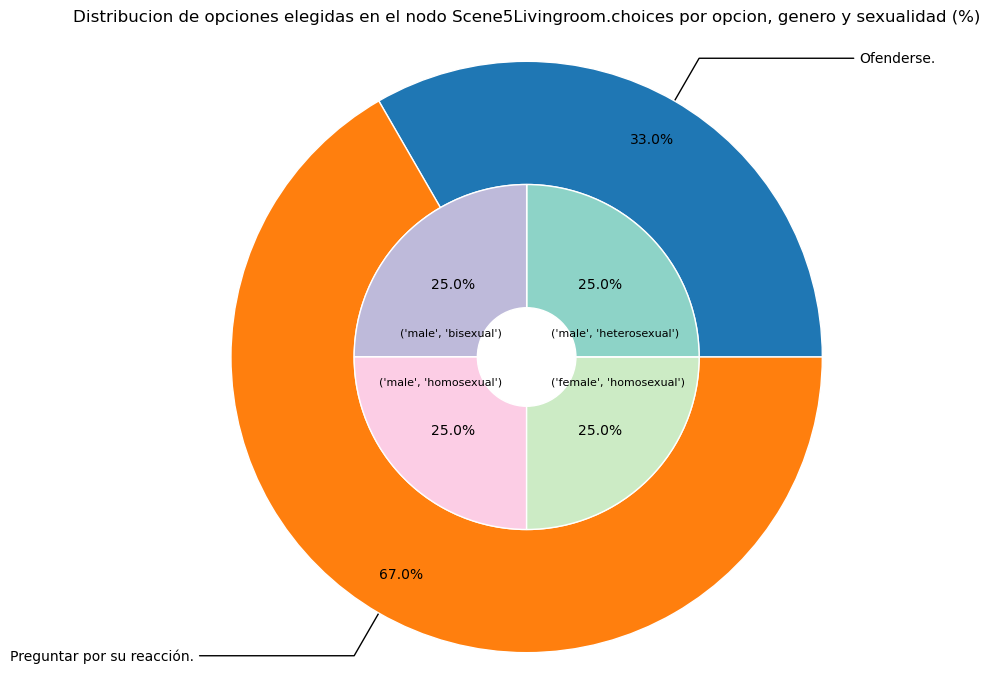

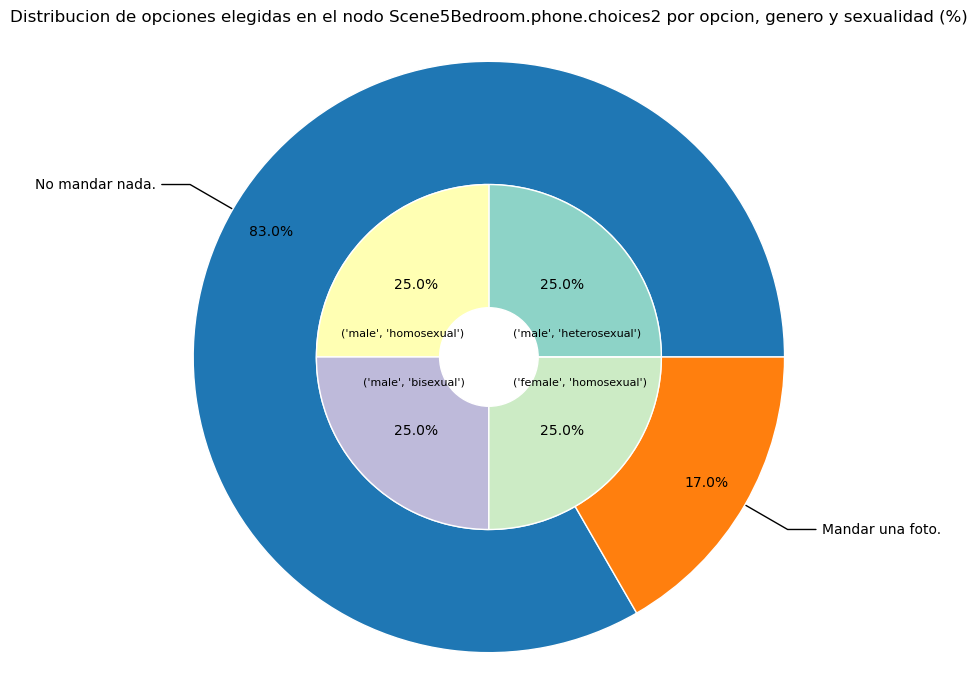

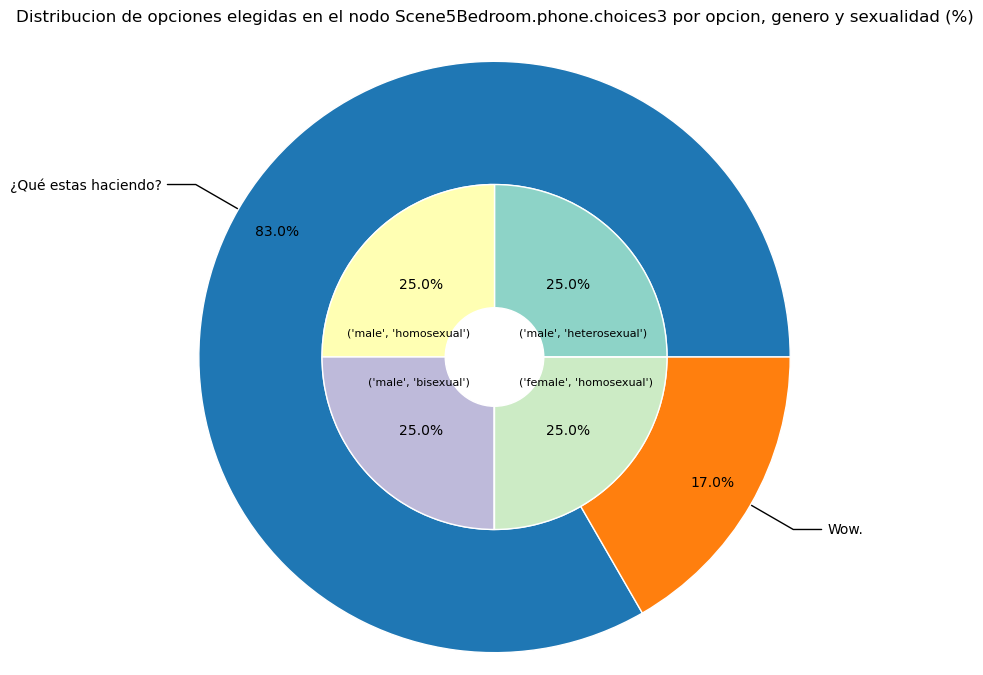

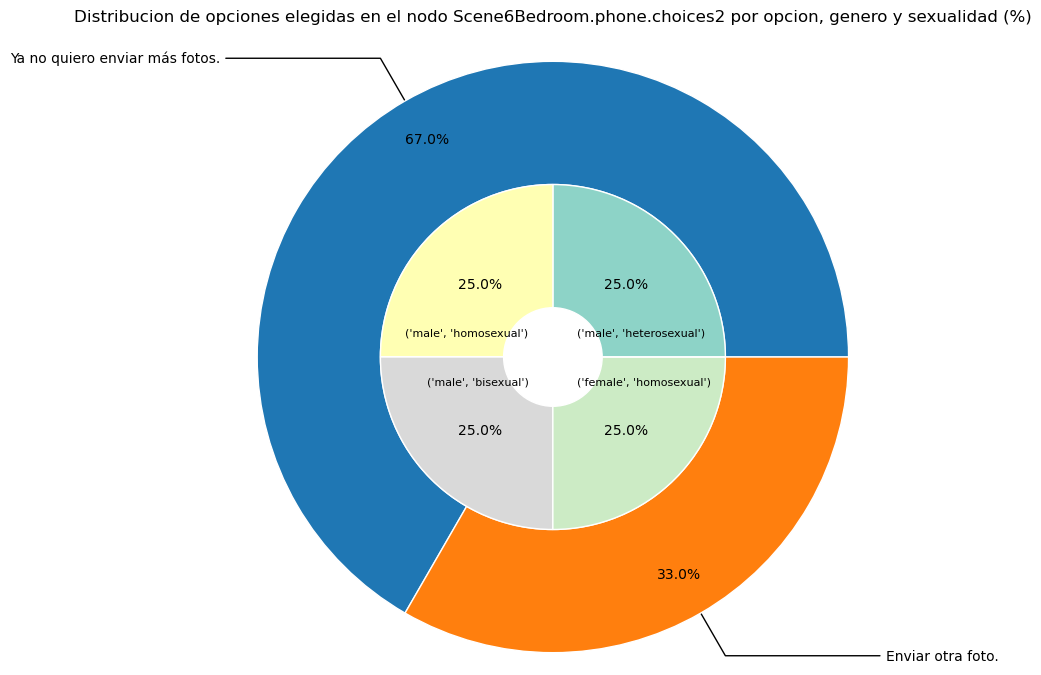

##########
APARTADO 1 a ii y 1 b ii
Porcentaje de obtención de cada final.
Porcentaje de obtención de cada final en base a los datos demográficos recogidos al inicio del juego:

routeB_explained: 66.66666666666666%
   ('male', 'heterosexual'): 25.0%
   ('male', 'homosexual'): 50.0%
   ('male', 'bisexual'): 25.0%
   ('female', 'heterosexual'): 0.0%
   ('female', 'homosexual'): 0.0%
   ('female', 'bisexual'): 0.0%

routeA: 33.33333333333333%
   ('male', 'heterosexual'): 0.0%
   ('male', 'homosexual'): 0.0%
   ('male', 'bisexual'): 50.0%
   ('female', 'heterosexual'): 0.0%
   ('female', 'homosexual'): 50.0%
   ('female', 'bisexual'): 0.0%


##########



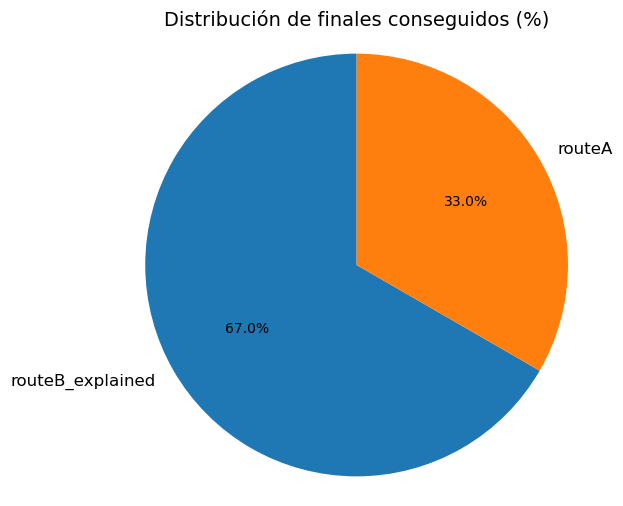

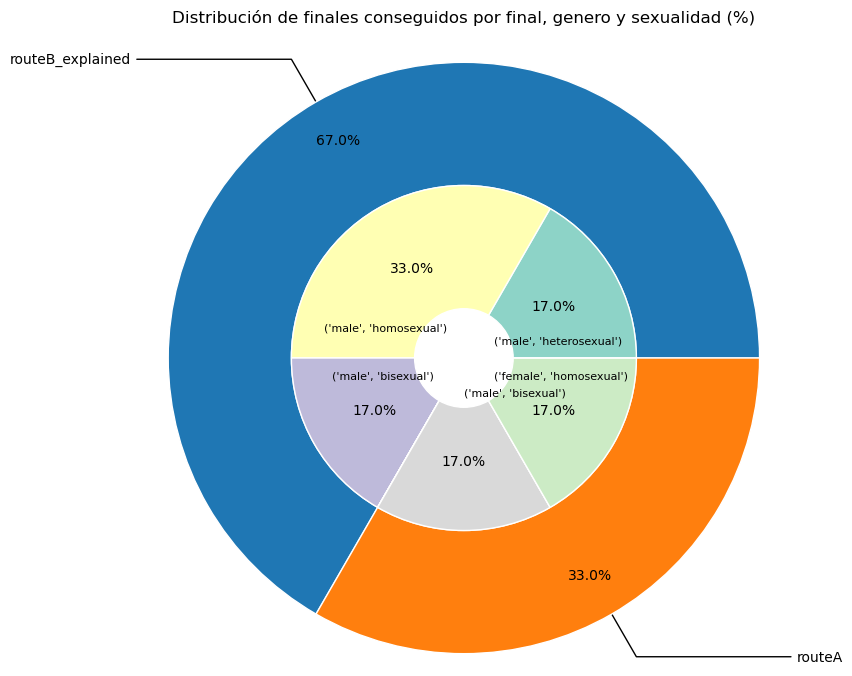

##########
APARTADO 1 c i y 2 e iii
Número medio de interacciones con los elementos de las redes sociales dentro del juego:
homeButton: 4.17
likeButton: 3.50
powerOffButton: 3.83
shareButton: 1.83
commentButton: 3.83
##########



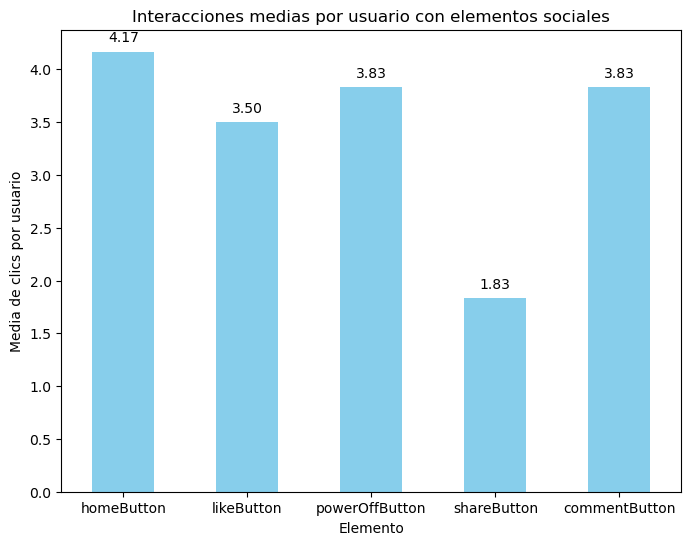

##########
APARTADO 1 c ii
Porcentaje de veces que se escucha a la amiga durante el recreo del dia 3:
0 veces: 33.33333333333333%
1 veces: 33.33333333333333%
2 veces: 33.33333333333333%
##########



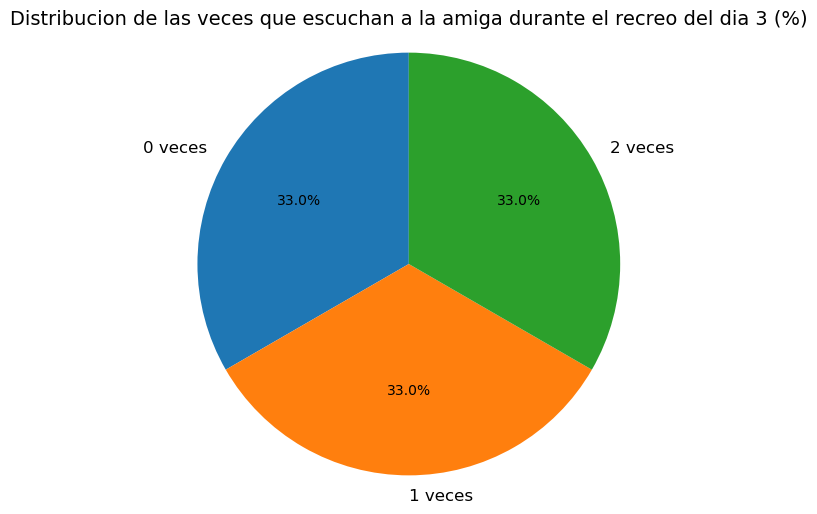

##########
APARTADO 2 a i
Media de tiempo de juego total:
992.5138333333334 segundos
##########

##########
APARTADO 2 a ii
Media de tiempo de juego desde que se pasa la pantalla de login:
973.5593333333333 segundos
##########

##########
APARTADO 2 a iii
Media de tiempo de juego en cada día:
Dia 1: 258.19233333333335 segundos
Dia 2: 103.57216666666666 segundos
Dia 3: 85.53633333333333 segundos
Dia 4: 179.69033333333334 segundos
Dia 5: 114.55166666666666 segundos
Dia 6: 187.06183333333334 segundos
Dia 7: 44.95466666666667 segundos
##########



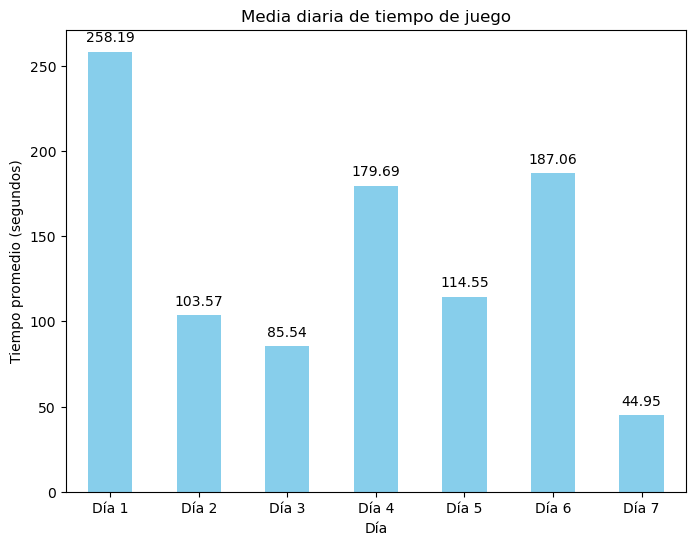

##########
APARTADO 2 b i
Número medio de veces que se pulsa sin éxito el botón de “aceptar” en la pantalla de login (si no ha seleccionado correctamente las opciones de personalización iniciales):
1.8333333333333333 veces
##########

##########
APARTADO 2 b ii
Número medio de veces que se pulsa el botón de responder en las pantallas de chat cuando no se puede responder:
19.0 veces
##########

##########
APARTADO 2 b iii
Porcentaje de las maneras en las que cierra los chats del móvil :
ChatReturnButton: 77.33%
PhoneReturnButton: 22.67%
##########



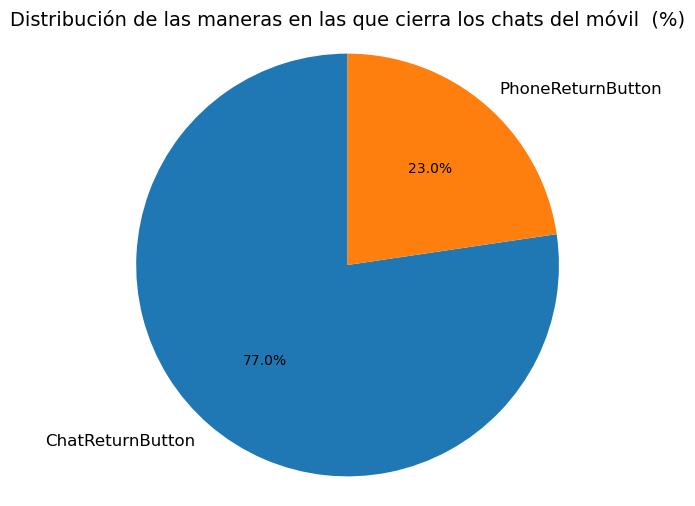

##########
APARTADO 2 b iv
Porcentaje de las maneras en las que cierra el móvil:
BlankArea: 64.58%
PhoneIcon: 20.83%
PhoneReturnButton: 14.58%
##########



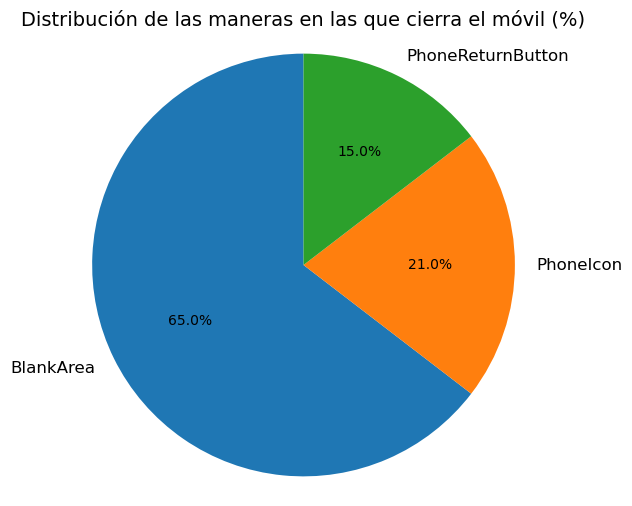

##########
APARTADO 2 b v
Mapa de calor de los lugares en los que se pulsa durante la pantalla del ordenador:
##########



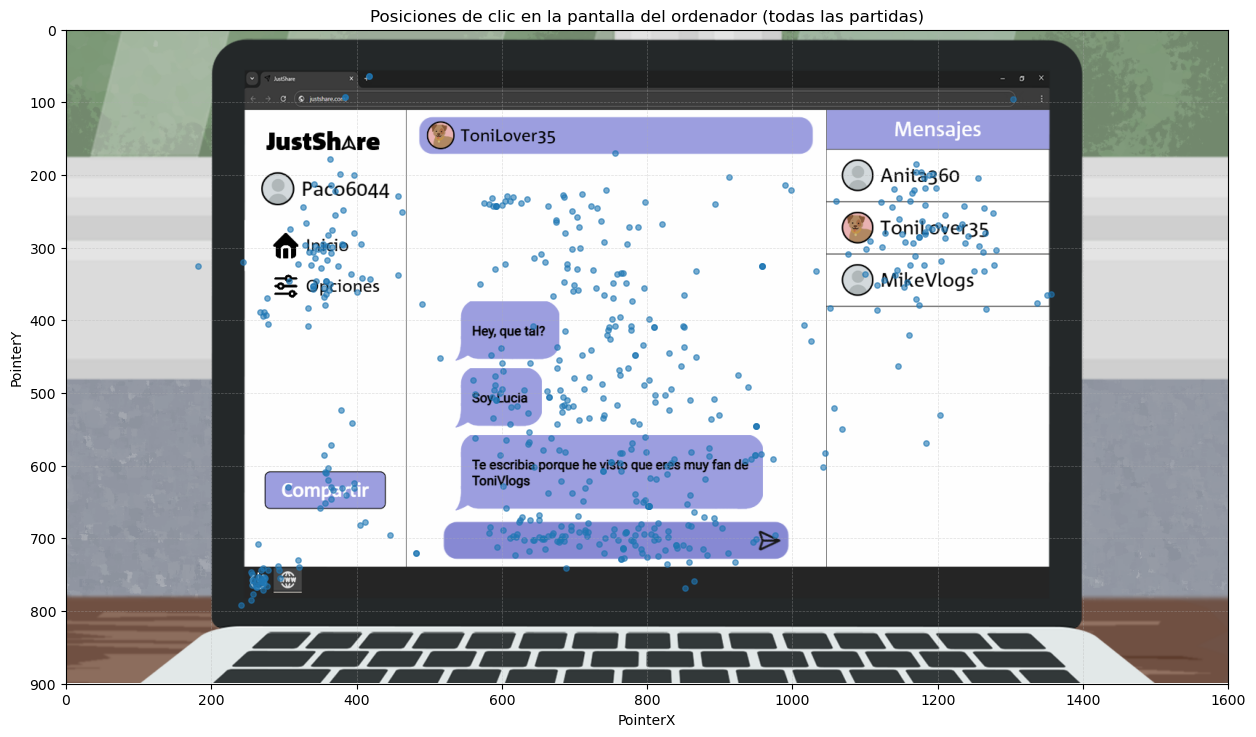

##########
APARTADO 2 c i
Tiempo medio que se queda leyendo las pantallas de transición:
1.4516637168141593 segundos
##########

##########
APARTADO 2 c ii
Tiempo medio que se queda leyendo cada diálogo:
##########



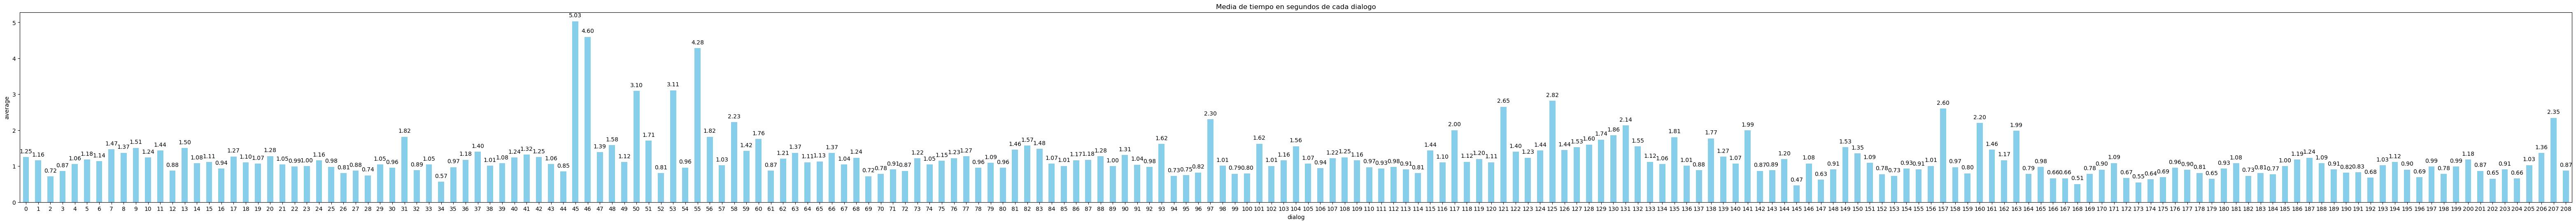

##########
APARTADO 2 d i
Tiempo medio transcurrido entre que el usuario recibe una notificación y consulta el teléfono:
7.817790322580644 segundos
##########

##########
APARTADO 2 d ii
Tiempo medio transcurrido entre que el usuario abre el móvil y se mete a un chat con una notificación:
4.574953846153846 segundos
##########

##########
APARTADO 2 d iii
Tiempo medio transcurrido entre que el usuario abre un chat con un mensaje que se puede contestar y pulsa el botón para contestar:
6.344590909090909 segundos
##########



In [1]:
import utils
import loader
import graphics
import pandas as pd
import numpy as np

# Usar las trazas de Simva o las de Scorm
use_scorm = False

files_path = "./trazas/simva/"
cols_to_drop = ["stored", "id", "version", "actor.account.homePage", "authority.name", "authority.homePage", "context.contextActivities.category", "context.registration", "object.definition.name.en-US", "object.definition.description.en-US", "object.definition.type", "verb.display.en-US", "verb.id", "object.objectType", "result.response", "result.score.scaled", "result.completion", "result.success"]

if use_scorm:
	files_path = "./trazas/scorm/"
	cols_to_drop = ["verb.display.en-US", "id", "stored", "version", "actor.objectType", "actor.account.homePage", "result.success", "result.completion", "context.registration", "authority.objectType", "authority.account.homePage", "authority.account.name", "authority.name", "object.definition.description.en-US", "object.definition.name.en-US", "object.objectType", "context.contextActivities.category"]

files_extension = "json"

############################
# Datos comunes
# Sacado de los JSONs
############################
all_users_df, users_individual_df_list = loader.load_all_files(files_path, files_extension, "timestamp", cols_to_drop, use_scorm)
n_users = len(users_individual_df_list)

game_starts_conditions = [("object.id", "GameStart")]
game_starts = utils.find_indices_by_conditions(all_users_df, game_starts_conditions)
game_starts = all_users_df.iloc[game_starts]
game_starts = game_starts.drop_duplicates(subset=["actor.account.name"])

gender_sexuality_combinations = [
	('male', 'heterosexual'), 
	('male', 'homosexual'), 
	('male', 'bisexual'), 
	('female', 'heterosexual'), 
	('female', 'homosexual'), 
	('female', 'bisexual')
]
demography = game_starts[["actor.account.name", "Gender", "Sexuality"]].values.tolist()

demography_info = {}
for user in demography:
	demography_info.update({user[0]: (user[1], user[2])})


############################
# APARTADO 1 a i,
# Porcentaje de elección de las diferentes respuestas cuando se presentan varias opciones en las siguientes situaciones:
#   Cuando habla con el acosador.
#   Al discutir con sus amigas en el cumpleaños.
#   Cuando le revela a su amiga que sale con el acosador.
#   Si decide o no contarle el problema a sus padres.

# APARTADO 1 b i,
# Porcentaje de elección de las diferentes respuestas en base a los datos demográficos recogidos al inicio del juego
############################

def get_choices_stats(all_users_df, nodes_names = [], gender_sexuality_combinations = [], demography_info = []): 
	# Dataframe solo con las filas en las que la columna Response no es nan
	choices_events = all_users_df.dropna(subset=["Response"])

	# Elimina las filas que tengan la misma respuesta, nodo y nombre de actor (por si acaso se envian duplicadas)
	choices_events = choices_events.drop_duplicates(subset=["Response", "actor.account.name", "Node"])

	# only_choices = only_choices.sort_values(by=["timestamp", "Node"])
	# unique_choices = only_choices["Response"].unique()
	# unique_nodes = only_choices["Node"].unique()

	
	# Respuestas distintas que tiene cada nodo
	different_responses_per_node = []

	# Numero de veces que se ha respondido cada nodo
	total_responses_per_node = []

	# Numero de veces que se ha respondido cada respuesta en cada nodo
	count_per_responses_per_node = []

	# Numero de veces que se ha respondido cada respuesta en cada nodo para cada grupo demografico 
	count_per_responses_per_node_per_demography = []

	# Recorrer todos los nodos que se quieren comprobar
	for node in nodes_names:
		# Obtener los distintos valores que pueden tener las respuestas de ese nodo
		responses = choices_events[choices_events["Node"] == node]
		unique_responses = responses["Response"].unique()

		different_responses_per_node.append(unique_responses)
		total_responses_per_node.append(len(responses.index))

		# Recorrer cada opcion del nodo
		response_count = []
		demographic_count_in_node = []
		for choice in unique_responses:
			# Obtener cuantas veces se ha elegido esa oopcion
			conditions = [("Node", node), ("Response", choice)]
			count = utils.find_indices_by_conditions(choices_events, conditions)

			response_count.append(len(count))
			
			# Guardar respuesta en base a la informacion demografica
			demographic_count_in_response = [0 for _ in range(len(gender_sexuality_combinations))]
			for user in demography_info:
				index = -1
				combination = demography_info[user]
				try:
					index = gender_sexuality_combinations.index(combination)
				except ValueError:
					pass
				
				count = 0
				if index >= 0:
					new_conditions = conditions + [("actor.account.name", user)]
					count = utils.find_indices_by_conditions(choices_events, new_conditions)
					count = len(count)
				
				demographic_count_in_response[index] = count
				
			demographic_count_in_node.append(demographic_count_in_response)

		count_per_responses_per_node.append(response_count)
		count_per_responses_per_node_per_demography.append(demographic_count_in_node)

	return different_responses_per_node, total_responses_per_node, count_per_responses_per_node, count_per_responses_per_node_per_demography


# Nodos cuyas respuestas se quieren comprobar
nodes_names = ["Scene1Bedroom1.computer1.choices", "Scene1Bedroom1.computer2.choices3", "Scene1Bedroom2.computer.choices", "Scene1Bedroom2.computer.choices2", "Scene2Bedroom.phone.choices", "Scene4Garage.photo.choices", "Scene4Garage.interruption.choices", "Scene4Bedroom.phone.choices", "Scene5Livingroom.choices", "Scene5Bedroom.phone.choices2", "Scene5Bedroom.phone.choices3", "Scene6Bedroom.phone.choices2", ]

different_responses_per_node, total_responses_per_node, count_per_responses_per_node, count_per_responses_per_node_per_demography = get_choices_stats(all_users_df, nodes_names, gender_sexuality_combinations, demography_info)
result = "\n"
for i in range (len(nodes_names)):
	result += f"Nodo {nodes_names[i]}:\n"
	for j in range(len(different_responses_per_node[i])):
		percentage1 = count_per_responses_per_node[i][j] / total_responses_per_node[i]
		percentage1 *= 100
		result += f"   {different_responses_per_node[i][j]}: {percentage1}%\n"

		for k in range(len(count_per_responses_per_node_per_demography[i][j])):
			percentage2 = count_per_responses_per_node_per_demography[i][j][k] / count_per_responses_per_node[i][j]
			percentage2 *= 100
			result += f"   	{gender_sexuality_combinations[k]}: {percentage2}%\n"

	result += "\n"
	
utils.show_metric(
	section="1 a i y 1 b i",
	title="Porcentaje de elección de las diferentes respuestas cuando se presentan varias opciones en las siguientes situaciones\nPorcentaje de elección de las diferentes respuestas en base a los datos demográficos recogidos al inicio del juego",
	info=result
)

# Mostrar las graficas
for i in range(len(nodes_names)):
	# graphics.display_pie_chart(count_per_responses_per_node[i], different_responses_per_node[i], nodes_names[i])
	labels = []
	for j in range (len(count_per_responses_per_node[i])):
		labels += gender_sexuality_combinations
	# HELPPPPPPPP
	graphics.display_nested_pie_chart(count_per_responses_per_node[i], count_per_responses_per_node_per_demography[i], different_responses_per_node[i], labels, f"Distribucion de opciones elegidas en el nodo {nodes_names[i]} por opcion, genero y sexualidad (%)")


############################
# APARTADO 1 a ii,
# Porcentaje de obtención de cada final.

# APARTADO 1 b ii,
# Porcentaje de obtención de cada final en base a los datos demográficos recogidos al inicio del juego
############################

def endings_obtained():
	conditions = [("object.id", "GameEnd"),("Ending", "notna")]
	ending_vals = []
	ending_by_user = { }

	for user in users_individual_df_list:

		# Ruta principal
		ending = utils.find_first_value_by_conditions(user, conditions, "Ending")
		
		# No hay final registrado
		if ending is None:
			continue
		# Si es routeB
		if ending == "routeB":
			extra_cond = conditions + [("Ending", "routeB")]
			explained_val = utils.find_first_value_by_conditions(user, extra_cond, "Explained")

			# True
			if explained_val:
				ending = "routeB_explained"
			# False o NaN
			else:
				ending = "routeB_not_explained"
		
		ending_by_user.update({user["actor.account.name"].unique()[0]: ending})
		ending_vals.append(ending)

	# Convertir a serie y calcular porcentajes
	ending_counts = pd.Series(ending_vals).value_counts()
	percentages = (ending_counts / n_users) * 100
	return ending_counts, percentages, ending_by_user


ending_counts, ending_percentages, ending_by_user = endings_obtained()


# Calcular numero de finales por datos demograficos
demographic_ending_counts = []
for i in range (len(ending_counts)):
	demographic_count_by_ending = [0 for _ in range(len(gender_sexuality_combinations))]
	for user in demography_info:
		index = -1
		combination = demography_info[user]
		try:
			index = gender_sexuality_combinations.index(combination)
		except ValueError:
			pass
		
		if (ending_by_user[user] == ending_counts.index[i]):
			demographic_count_by_ending[index] += 1

	demographic_ending_counts.append(demographic_count_by_ending)


result = "\n"
for i in range (len(ending_counts)):
	result += f"{ending_counts.index[i]}: {ending_percentages.iloc[i]}%\n"
	 
	for j in range (len(demographic_ending_counts[i])):
		percentage = demographic_ending_counts[i][j] / ending_counts.iloc[i]
		percentage *= 100
		result += f"   {gender_sexuality_combinations[j]}: {percentage}%\n"

	result += "\n"

utils.show_metric(
	section="1 a ii y 1 b ii",
	title="Porcentaje de obtención de cada final.\nPorcentaje de obtención de cada final en base a los datos demográficos recogidos al inicio del juego",
	info=result
)

# HELPPPPPPPP
graphics.display_pie_chart(
	values=ending_percentages.values,
	labels=ending_percentages.index,
	title="Distribución de finales conseguidos (%)"
)

labels = []
for i in range(len(ending_counts)):
	labels += gender_sexuality_combinations
graphics.display_nested_pie_chart(ending_counts.values, demographic_ending_counts, ending_counts.index, labels, "Distribución de finales conseguidos por final, genero y sexualidad (%)")


############################
# APARTADO 1 c i y 2 e iii,
# Número medio de interacciones con los elementos de las redes sociales dentro del juego
############################

def social_media_elements():
	conditions = [("object.id", "ObjectInteraction")]
	social_media = utils.find_values_by_conditions(all_users_df, conditions, "Object")
	# Nos quedamos solo con los botones deseados
	counts_all = pd.Series(social_media).value_counts()

	validObj = {"powerOffButton", "commentButton", "likeButton", "homeButton", "shareButton"}

   # Mantener solo los válidos y rellenar con 0 los que falten
	counts_valid = counts_all.reindex(validObj, fill_value=0)

	# Número medio de interacciones por usuario
	avg_interactions = counts_valid / n_users
	return avg_interactions
   
socialMedia_avg = social_media_elements()

utils.show_metric(
	section="1 c i y 2 e iii",
	title="Número medio de interacciones con los elementos de las redes sociales dentro del juego",
	info="\n".join([f"{elem}: {avg:.2f}" for elem, avg in socialMedia_avg.items()])
)

# HELP
graphics.display_bar_chart(
	socialMedia_avg,
	title="Interacciones medias por usuario con elementos sociales",
	ylabel="Media de clics por usuario",
	xlabel="Elemento",
	bar_color="skyblue"
)


############################
# APARTADO 1 c ii,
# Porcentaje de veces que escuchan a su amiga en el recreo antes de abrir el móvil (1,2 o 3 veces)
############################
conditions = [("object.id", "Day3BreakConversation")]
conversation_events = utils.find_indices_by_conditions(all_users_df, conditions)
conversation_events = all_users_df.iloc[conversation_events]
unique_values = [0, 1, 2]

times_listened = []
total_times = 0
for times in unique_values:
	condition = [("TimesListened", times)]
	count = utils.find_indices_by_conditions(conversation_events, condition)
	times_listened.append(len(count))
	total_times += len(count)

utils.show_metric(
	section="1 c ii",
	title="Porcentaje de veces que se escucha a la amiga durante el recreo del dia 3",
	info="\n".join([f"{i} veces: {(times_listened[i] / total_times) * 100}%" for i in range(len(times_listened))])
)
graphics.display_pie_chart(times_listened, [f"{i} veces" for i in range(len(times_listened))], "Distribucion de las veces que escuchan a la amiga durante el recreo del dia 3 (%)")


############################
# APARTADO 2 a i,
# Media de tiempo de juego total
############################

def average_total_time(sessions):
	durations  = []
	start_conditions = [("object.id", "SessionStart")]
	end_conditions = [("object.id", "SessionEnd")]
	
	for user in users_individual_df_list:
		start_idx = utils.find_first_index_by_conditions(user, start_conditions)
		end_idx = utils.find_first_index_by_conditions(user, end_conditions)
		d = utils.time_between_indices(user,start_idx,end_idx)
		durations.append(d)
	return sum(durations ) / len(durations ) if durations  else 0

utils.show_metric(
	section="2 a i",
	title="Media de tiempo de juego total",
	info=f"{average_total_time(users_individual_df_list)} segundos"
)


############################
# APARTADO 2 a ii,
# Media de tiempo de juego desde que se pasa de la pantalla de login
############################
def average_login_time(sessions):
	durations  = []
	start_conditions = [("object.id", "GameStart")]
	end_conditions = [("object.id", "GameEnd")]
	
	for user in users_individual_df_list:
		start_idx = utils.find_first_index_by_conditions(user, start_conditions)
		end_idx = utils.find_first_index_by_conditions(user, end_conditions)
		d = utils.time_between_indices(user,start_idx,end_idx)
		durations.append(d)
	return sum(durations ) / len(durations ) if durations  else 0

utils.show_metric(
	section="2 a ii",
	title="Media de tiempo de juego desde que se pasa la pantalla de login",
	info=f"{average_login_time(users_individual_df_list)} segundos"
)


############################
# APARTADO 2 a iii,
# Media de tiempo de juego en cada día.
############################

def average_daily_time(users_individual_df_list):
	conditions = [("object.id", "GameProgress")]
	start_conditions = [("object.id", "GameStart")]
	end_conditions = [("object.id", "GameEnd")]

	# Duraciones de todos los dias. Cada elemento de la lista es otra lista con la duracion de ese dia para cada usuario
	all_durations = [[] for _ in range(7)]

	for user in users_individual_df_list:
		# Indices de los eventos que se van a usar para calcular los tiempos
		indexes = []

		# Indice del evento de inicio del juego
		indexes.append(utils.find_first_index_by_conditions(user, start_conditions))

		# Indices de los eventos de progreso en el juego
		progress_indexes = utils.find_indices_by_conditions(user, conditions)
		aux = []

		# Recorre todos los indices de los eventos de progreso y solo se guardan si el dia no esta repetido (por si se repiten los eventos)
		for i in range (len(progress_indexes)):
			day = user.loc[progress_indexes[i], "EndingDay"]
			if not (day in aux):
				aux.append(day)
				indexes.append(progress_indexes[i])

		# Indice del evento de final del juego
		indexes.append(utils.find_first_index_by_conditions(user, end_conditions))
		
		# Si hay 8 indices (inicio, 6 dias y fin), se calculan los tiempos para el usuario y se guardan
		if len(indexes) == 8:
			for i in range (len(indexes) - 1):
				time = utils.time_between_indices(user, indexes[i], indexes[i + 1])
				all_durations[i].append(time)

	day_means = [np.mean(durations) if len(durations) > 0 else 0 for durations in all_durations]
	return day_means

daily_times = average_daily_time(users_individual_df_list)
result = "\n".join([f"Dia {i+1}: {value} segundos" for i, value in enumerate(daily_times)])
utils.show_metric(
	section="2 a iii",
	title="Media de tiempo de juego en cada día",
	info=result
)
df = pd.DataFrame({"Media (segundos)": daily_times}, index=[f"Día {i+1}" for i in range(7)])
graphics.display_bar_chart(df,title="Media diaria de tiempo de juego",ylabel="Tiempo promedio (segundos)",xlabel="Día",bar_color="skyblue")


############################
# APARTADO 2 b i,
# Número medio de veces que se pulsa sin éxito el botón de “aceptar” en la pantalla de login (si no ha seleccionado correctamente las opciones de personalización iniciales).
############################

login = all_users_df[all_users_df["Object"] == "loginButton"].index
game_initialized = all_users_df[(all_users_df["object.id"] == "GameStart")].index
utils.show_metric(
	section="2 b i",
	title="Número medio de veces que se pulsa sin éxito el botón de “aceptar” en la pantalla de login (si no ha seleccionado correctamente las opciones de personalización iniciales)",
	info=f"{(login.size - game_initialized.size) / n_users} veces"
)


############################
# APARTADO 2 b ii,
# Número medio de veces que se pulsa el botón de responder en las pantallas de chat cuando no se puede responder.
############################

reply = all_users_df[(all_users_df["object.id"] == "ObjectInteraction") & (all_users_df["Object"] == "phoneAnswerButton")]
answers = all_users_df[all_users_df["object.id"] == "AnswerChat"]
utils.show_metric(
	"2 b ii", 
	"Número medio de veces que se pulsa el botón de responder en las pantallas de chat cuando no se puede responder", 
	f"{(reply.index.size - answers.index.size) / n_users} veces"
)


############################
# APARTADO 2 b iii,
# Porcentaje de las maneras en las que cierra los chats del móvil (pulsando el botón de atrás del móvil o el de la pantalla de chat).
############################

def exitChatMethod():
	conditions = [("object.id", "ExitChat")]
	exit = utils.find_values_by_conditions(all_users_df, conditions, "Method")
	exit_counts = pd.Series(exit).value_counts()
	percentages = (exit_counts / exit_counts.sum()) * 100
	return percentages
   
exit_percentages = exitChatMethod()
utils.show_metric(
	section="2 b iii",
	title="Porcentaje de las maneras en las que cierra los chats del móvil ",
	info="\n".join([f"{exit}: {pct:.2f}%" 
							for exit, pct in exit_percentages.items()])
)
graphics.display_pie_chart(
	values=exit_percentages.values,
	labels=exit_percentages.index,
	title="Distribución de las maneras en las que cierra los chats del móvil  (%)"
)


############################
# APARTADO 2 b iv,
# Porcentaje de las maneras en las que cierra el móvil (pulsando el botón de atrás o en cualquier zona de la pantalla fuera del móvil).
############################

def exitMobileMethod():
	conditions = [("object.id", "ObjectInteraction"),("Object", "phone"),("Closing",True)]
	exit = utils.find_values_by_conditions(all_users_df, conditions, "Method")
	exit_counts = pd.Series(exit).value_counts()
	percentages = (exit_counts / exit_counts.sum()) * 100
	return percentages
   
exit_percentages = exitMobileMethod()
utils.show_metric(
	section="2 b iv",
	title="Porcentaje de las maneras en las que cierra el móvil",
	info="\n".join([f"{exit}: {pct:.2f}%" 
							for exit, pct in exit_percentages.items()])
)

graphics.display_pie_chart(
	values=exit_percentages.values,
	labels=exit_percentages.index,
	title="Distribución de las maneras en las que cierra el móvil (%)"
)


############################
# APARTADO 2 b v,
# Mapa de calor de los lugares en los que se pulsa durante la pantalla del ordenador
############################
def computerScreenPos():
	conditions = [("object.id", "ComputerScreenClick")]
	X = utils.find_values_by_conditions(all_users_df, conditions, "PointerX")
	Y= utils.find_values_by_conditions(all_users_df, conditions, "PointerY")
	return X,Y
   
computerScreenPosX,computerScreenPosY = computerScreenPos()
utils.show_metric(
	section="2 b v",
	title="Mapa de calor de los lugares en los que se pulsa durante la pantalla del ordenador",
	info=""
)

# Grafica
graphics.display_heatmap(computerScreenPosX, computerScreenPosY, 
						 "Posiciones de clic en la pantalla del ordenador (todas las partidas)", "./heatmapImg.png")

############################
# APARTADO 2 c i
# Tiempo medio que se queda leyendo las pantallas de transición.
############################
def average_transition_time(users_individual_df_list):
    conditions = [("Scene", "TextOnlyScene")]
    durations=[]
    for user in users_individual_df_list:
        indexes = utils.find_indices_by_conditions(user, conditions)
        for index in indexes:
            pos = user.index.get_loc(index)
            if pos + 1 < len(user):
                next_idx = user.index[index + 1]
                if user.loc[next_idx, 'object.id'] == 'EnterScene':
                    value= utils.time_between_indices(user,index, next_idx)
                    durations.append(value)

    return  durations

durations=average_transition_time(users_individual_df_list)
mean=np.mean(durations)
utils.show_metric(
	section="2 c i",
	title="Tiempo medio que se queda leyendo las pantallas de transición",
	info=f"{mean} segundos"
)


############################
# APARTADO 2 c ii,
# Tiempo medio que se queda leyendo cada diálogo.
############################
def average_dialog_time(users_individual_df_list):
    conditions = [("object.id", "DialogStart")]
    diccionary = {}

    for user in users_individual_df_list:
        indexes = utils.find_indices_by_conditions(user, conditions)
        for index in indexes:
            end_condition= [("object.id","DialogEnd"),("Node",user.loc[index, "Node"])]
            end_index= utils.find_first_index_by_conditions(user,end_condition,index)
            if end_index:
              key= user.loc[index, "Node"]
              value= utils.time_between_indices(user,index, end_index)
              if key not in diccionary:
                 diccionary[key] = []
            text= user.loc[index, "Dialog.text"]
            diccionary[key].append(value) 
            
    average  = {}

    for key, value in diccionary.items():
        average [key] = sum(value) / len(value)

    return average


average = average_dialog_time(users_individual_df_list)
text = ""
for key, value in average.items():
    text += f"Media para '{key}': {value:.2f}\n"

all_values = [v for v in average.values()]
overall_average = sum(all_values) / len(all_values)
text+= f"Media total: {overall_average:.2f}"
#print(text)
#
utils.show_metric(
	section="2 c ii",
	title="Tiempo medio que se queda leyendo cada diálogo",
	info=""
)
df_average = pd.DataFrame(list(average.items()), columns=['dialog', 'average'])
graphics.display_bar_chart(df_average,title="Media de tiempo en segundos de cada dialogo",ylabel="average",xlabel="dialog",bar_color="skyblue",sizex=80)


############################
# APARTADO 2 d i
# Tiempo medio transcurrido entre que el usuario recibe una notificación y consulta el teléfono.

# APARTADO 2 d ii
# Tiempo medio transcurrido entre que el usuario abre el móvil y se mete a un chat con una notificación.

# APARTADO 2 d iii
# Tiempo medio transcurrido entre que el usuario abre un chat con un mensaje que se puede contestar y pulsa el botón para contestar.
############################

def get_average_time_difference_between_phone_events(first_conditions, last_conditions):
	time_differences = []
	
	# Recorre todos los usuarios
	for user in users_individual_df_list:
		all_last_to_happen = utils.find_indices_by_conditions(user, last_conditions)

		first_to_happen = []
		last_to_happen = []

		# Recorre todos los indices del evento que sucede despues
		for i in range(len(all_last_to_happen)):
			# Encuentra el evento que sucede primero inmediatamente anterior al indice
			immediate_prev = utils.find_indices_by_conditions(user.iloc[:all_last_to_happen[i]], first_conditions)

			# Si se encuentra algun evento anterior 
			if len(immediate_prev) > 0:
				# Si el indice del evento anterior no estaba en la lista de indices anteriores
				if not (immediate_prev[-1] in first_to_happen):
					# Se guardan los indices de ambos eventos
					first_to_happen.append(immediate_prev[-1])
					last_to_happen.append(all_last_to_happen[i])

		for i in range(len(first_to_happen)):
			difference = utils.time_between_indices(user, first_to_happen[i], last_to_happen[i])
			time_differences.append(difference)

	return sum(time_differences) / len(time_differences) if len(time_differences) > 0 else 0

first_conditions = [("object.id", "NotificationReceived")]
last_conditions = [("object.id", "ObjectInteraction"), ("Object", "phone"), ("Closing", False)]

utils.show_metric(
	section="2 d i",
	title="Tiempo medio transcurrido entre que el usuario recibe una notificación y consulta el teléfono",
	info=f"{get_average_time_difference_between_phone_events(first_conditions, last_conditions)} segundos"
)


first_conditions = [("object.id", "ObjectInteraction"), ("Object", "phone"), ("Closing", False)]
last_conditions = [("object.id", "NotificationSeen")]

utils.show_metric(
	section="2 d ii",
	title="Tiempo medio transcurrido entre que el usuario abre el móvil y se mete a un chat con una notificación",
	info=f"{get_average_time_difference_between_phone_events(first_conditions, last_conditions)} segundos"
)


first_conditions = [("object.id", "CanAnswerChat")]
last_conditions = [("object.id", "AnswerChat")]

utils.show_metric(
	section="2 d iii",
	title="Tiempo medio transcurrido entre que el usuario abre un chat con un mensaje que se puede contestar y pulsa el botón para contestar",
	info=f"{get_average_time_difference_between_phone_events(first_conditions, last_conditions)} segundos"
)